In [ ]:
#importing libraries and modules
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import cv2
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import argparse
import sys
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split

In [ ]:
# argument parser

parser = argparse.ArgumentParser()
parser.add_argument('-e', '--epochs', type=int, default=40, help='number of epochs')

args = vars(parser.parse_args(['-e', '40']))

def save_decode_image(img, name):
    img = img.view(img.size(0), 3, 224, 224)
    save_image(img, name)

In [ ]:
# create folders for saved images
image_dir = '/content/drive/MyDrive/blur_images/outputs/saved_images_v3'
os.makedirs(image_dir, exist_ok=True)

batch_size = 3

In [ ]:
# get image paths
gauss_blur = os.listdir('/content/drive/MyDrive/blur_images/gaussian_blurred')
gauss_blur.sort()
sharp = os.listdir('/content/drive/MyDrive/blur_images/sharp')
sharp.sort()

x_blur = []
for i in range(len(gauss_blur)):
    x_blur.append(gauss_blur[i])
y_sharp = []
for i in range(len(sharp)):
    y_sharp.append(sharp[i])

In [ ]:
# train test split and validation
(x_train, x_val, y_train, y_val) = train_test_split(x_blur, y_sharp, test_size=0.25)
print(f"Train data instances: {len(x_train)}")
print(f"Validation data instances: {len(x_val)}")

Train data instances: 262
Validation data instances: 88


In [ ]:
# transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
# deblur dataset class
class DeblurDataset(Dataset):
    def __init__(self, blur_paths, sharp_paths=None, transform=None):
        self.x = blur_paths
        self.y = sharp_paths
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        blur_image = cv2.imread(f"/content/drive/MyDrive/blur_images/gaussian_blurred/{self.x[index]}")

        if self.transform:
            blur_image = self.transform(blur_image)

        if self.y is not None:
            sharp_image = cv2.imread(f"/content/drive/MyDrive/blur_images/sharp/{self.y[index]}")
            sharp_image = self.transform(sharp_image)
            return blur_image, sharp_image
        else:
            return blur_image



In [ ]:
# define train, validation, and loader data
train_data = DeblurDataset(x_train, y_train, transform)
val_data = DeblurDataset(x_val, y_val, transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [ ]:
# custom CNN architecture
class DeblurCNN(nn.Module):
    def __init__(self):
        super(DeblurCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=2)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)

        return x

model = DeblurCNN()
print(model)

DeblurCNN(
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)


In [ ]:
# optimizer and loss
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5,
    verbose=True
)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# training function
def fit(model, dataloader, epoch):
    model.train()
    running_loss = 0.5
    for i, data in tqdm(enumerate(dataloader), total=len(dataloader)):
        blur_image = data[0]
        sharp_image = data[1]
        optimizer.zero_grad()
        outputs = model(blur_image)
        loss = criterion(outputs, sharp_image)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss/len(dataloader.dataset)
    print(f"Train loss: {train_loss:.5f}")

    return train_loss




In [ ]:
# validate function
def validate(model, dataloader, epoch):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            blur_image = data[0]
            sharp_image = data[1]
            outputs = model(blur_image)
            loss = criterion(outputs, sharp_image)
            running_loss += loss.item()

            if epoch == 0 and i == int((len(val_data)/dataloader.batch_size)-1):
                save_decode_image(outputs.cpu().data, name = f"/content/drive/MyDrive/blur_images/outputs/saved_images_v3/sharp{epoch}.jpg")
                save_decode_image(blur_image.cpu().data, name = f"/content/drive/MyDrive/blur_images/outputs/saved_images_v3/blur{epoch}.jpg")

            if i == int((len(val_data)/dataloader.batch_size)-1):
                save_decode_image(outputs.cpu().data, name = f"/content/drive/MyDrive/blur_images/outputs/saved_images_v3/val_deblurred{epoch}.jpg")

    val_loss = running_loss/len(dataloader.dataset)
    print(f"Validation loss: {val_loss:.5f}")

    return val_loss

Epoch 1 of 40


100%|██████████| 88/88 [05:43<00:00,  3.91s/it]


Train loss: 0.00735


30it [01:42,  3.42s/it]


Validation loss: 0.00235
Epoch 2 of 40


100%|██████████| 88/88 [00:59<00:00,  1.47it/s]


Train loss: 0.00343


30it [00:14,  2.06it/s]


Validation loss: 0.00126
Epoch 3 of 40


100%|██████████| 88/88 [01:01<00:00,  1.43it/s]


Train loss: 0.00310


30it [00:14,  2.06it/s]


Validation loss: 0.00105
Epoch 4 of 40


100%|██████████| 88/88 [00:59<00:00,  1.48it/s]


Train loss: 0.00304


30it [00:14,  2.04it/s]


Validation loss: 0.00090
Epoch 5 of 40


100%|██████████| 88/88 [01:00<00:00,  1.44it/s]


Train loss: 0.00278


30it [00:14,  2.04it/s]


Validation loss: 0.00082
Epoch 6 of 40


100%|██████████| 88/88 [01:00<00:00,  1.45it/s]


Train loss: 0.00282


30it [00:14,  2.07it/s]


Validation loss: 0.00258
Epoch 7 of 40


100%|██████████| 88/88 [01:00<00:00,  1.47it/s]


Train loss: 0.00311


30it [00:14,  2.06it/s]


Validation loss: 0.00072
Epoch 8 of 40


100%|██████████| 88/88 [01:00<00:00,  1.47it/s]


Train loss: 0.00258


30it [00:14,  2.04it/s]


Validation loss: 0.00064
Epoch 9 of 40


100%|██████████| 88/88 [01:00<00:00,  1.45it/s]


Train loss: 0.00249


30it [00:14,  2.07it/s]


Validation loss: 0.00064
Epoch 10 of 40


100%|██████████| 88/88 [00:59<00:00,  1.49it/s]


Train loss: 0.00253


30it [00:14,  2.05it/s]


Validation loss: 0.00049
Epoch 11 of 40


100%|██████████| 88/88 [01:00<00:00,  1.46it/s]


Train loss: 0.00237


30it [00:16,  1.83it/s]


Validation loss: 0.00044
Epoch 12 of 40


100%|██████████| 88/88 [00:58<00:00,  1.49it/s]


Train loss: 0.00236


30it [00:14,  2.09it/s]


Validation loss: 0.00041
Epoch 13 of 40


100%|██████████| 88/88 [00:58<00:00,  1.50it/s]


Train loss: 0.00231


30it [00:14,  2.10it/s]


Validation loss: 0.00036
Epoch 14 of 40


100%|██████████| 88/88 [01:00<00:00,  1.47it/s]


Train loss: 0.00257


30it [00:14,  2.12it/s]


Validation loss: 0.00041
Epoch 15 of 40


100%|██████████| 88/88 [00:58<00:00,  1.51it/s]


Train loss: 0.00228


30it [00:14,  2.09it/s]


Validation loss: 0.00034
Epoch 16 of 40


100%|██████████| 88/88 [01:00<00:00,  1.46it/s]


Train loss: 0.00223


30it [00:15,  1.93it/s]


Validation loss: 0.00031
Epoch 17 of 40


100%|██████████| 88/88 [01:02<00:00,  1.41it/s]


Train loss: 0.00222


30it [00:14,  2.06it/s]


Validation loss: 0.00030
Epoch 18 of 40


100%|██████████| 88/88 [01:00<00:00,  1.46it/s]


Train loss: 0.00226


30it [00:14,  2.06it/s]


Validation loss: 0.00124
Epoch 19 of 40


100%|██████████| 88/88 [01:00<00:00,  1.45it/s]


Train loss: 0.00234


30it [00:14,  2.07it/s]


Validation loss: 0.00032
Epoch 20 of 40


100%|██████████| 88/88 [01:01<00:00,  1.43it/s]


Train loss: 0.00219


30it [00:14,  2.08it/s]


Validation loss: 0.00026
Epoch 21 of 40


100%|██████████| 88/88 [00:59<00:00,  1.47it/s]


Train loss: 0.00216


30it [00:14,  2.07it/s]


Validation loss: 0.00025
Epoch 22 of 40


100%|██████████| 88/88 [01:00<00:00,  1.45it/s]


Train loss: 0.00217


30it [00:14,  2.08it/s]


Validation loss: 0.00024
Epoch 23 of 40


100%|██████████| 88/88 [01:01<00:00,  1.44it/s]


Train loss: 0.00221


30it [00:14,  2.02it/s]


Validation loss: 0.00025
Epoch 24 of 40


100%|██████████| 88/88 [01:00<00:00,  1.45it/s]


Train loss: 0.00214


30it [00:14,  2.01it/s]


Validation loss: 0.00034
Epoch 25 of 40


100%|██████████| 88/88 [01:00<00:00,  1.45it/s]


Train loss: 0.00217


30it [00:15,  1.91it/s]


Validation loss: 0.00026
Epoch 26 of 40


100%|██████████| 88/88 [01:00<00:00,  1.45it/s]


Train loss: 0.00214


30it [00:14,  2.05it/s]


Validation loss: 0.00028
Epoch 27 of 40


100%|██████████| 88/88 [00:59<00:00,  1.47it/s]


Train loss: 0.00216


30it [00:14,  2.03it/s]


Validation loss: 0.00023
Epoch 28 of 40


100%|██████████| 88/88 [01:03<00:00,  1.39it/s]


Train loss: 0.00220


30it [00:15,  1.99it/s]


Validation loss: 0.00044
Epoch 29 of 40


100%|██████████| 88/88 [01:00<00:00,  1.46it/s]


Train loss: 0.00229


30it [00:15,  1.97it/s]


Validation loss: 0.00023
Epoch 30 of 40


100%|██████████| 88/88 [01:01<00:00,  1.43it/s]


Train loss: 0.00211


30it [00:14,  2.01it/s]


Validation loss: 0.00020
Epoch 31 of 40


100%|██████████| 88/88 [01:02<00:00,  1.42it/s]


Train loss: 0.00210


30it [00:14,  2.03it/s]


Validation loss: 0.00020
Epoch 32 of 40


100%|██████████| 88/88 [01:01<00:00,  1.44it/s]


Train loss: 0.00214


30it [00:14,  2.03it/s]


Validation loss: 0.00024
Epoch 33 of 40


100%|██████████| 88/88 [01:01<00:00,  1.42it/s]


Train loss: 0.00217


30it [00:14,  2.02it/s]


Validation loss: 0.00020
Epoch 34 of 40


100%|██████████| 88/88 [01:00<00:00,  1.45it/s]


Train loss: 0.00210


30it [00:14,  2.06it/s]


Validation loss: 0.00018
Epoch 35 of 40


100%|██████████| 88/88 [01:00<00:00,  1.46it/s]


Train loss: 0.00214


30it [00:14,  2.05it/s]


Validation loss: 0.00021
Epoch 36 of 40


100%|██████████| 88/88 [01:01<00:00,  1.42it/s]


Train loss: 0.00336


30it [00:14,  2.06it/s]


Validation loss: 0.00085
Epoch 37 of 40


100%|██████████| 88/88 [01:01<00:00,  1.43it/s]


Train loss: 0.00232


30it [00:14,  2.06it/s]


Validation loss: 0.00025
Epoch 38 of 40


100%|██████████| 88/88 [00:59<00:00,  1.47it/s]


Train loss: 0.00211


30it [00:14,  2.09it/s]


Validation loss: 0.00020
Epoch 39 of 40


100%|██████████| 88/88 [01:01<00:00,  1.43it/s]


Train loss: 0.00209


30it [00:14,  2.03it/s]


Validation loss: 0.00019
Epoch 40 of 40


100%|██████████| 88/88 [01:01<00:00,  1.42it/s]


Train loss: 0.00208


30it [00:14,  2.04it/s]


Validation loss: 0.00018
Total time taken: 56.434 minutes


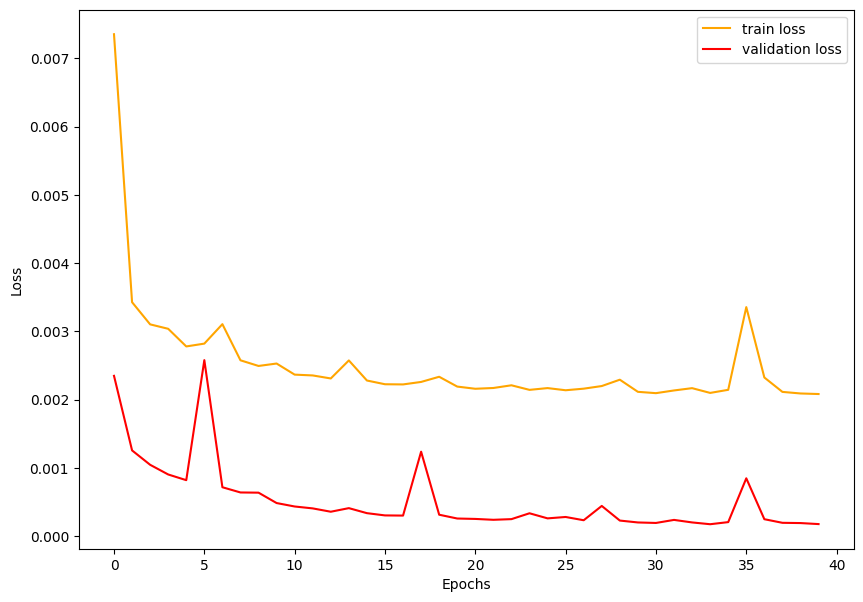

Model saved


In [ ]:
# run the script
train_loss = []
val_loss = []
start = time.time()
for epoch in range(args['epochs']):
    print(f"Epoch {epoch+1} of {args['epochs']}")
    train_epoch_loss = fit(model, train_loader, epoch)
    val_epoch_loss = validate(model, val_loader, epoch)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    scheduler.step(val_epoch_loss)
end = time.time()
print(f"Total time taken: {((end-start)/60):.3f} minutes")

# plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/blur_images/outputs/lossv3.png')
plt.show()

#save model
torch.save(model.state_dict(), '/content/drive/MyDrive/blur_images/outputs/modelv3.pth')
print('Model saved')